# DQN
일단 강화학습 연습해보자.
(pytorch)[https://tutorials.pytorch.kr/intermediate/reinforcement_q_learning.html]

In [14]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

print(torch.cuda.is_available())


True


In [15]:
env = gym.make('CartPole-v1')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [17]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [18]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

n_actions = env.action_space.n
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.Adam(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY) 
    steps_done += 1

    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)],], device=device, dtype=torch.long)
    
episode_durations = []

def plot_durations(show_result=False):
    plt.figure(2)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())

    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.clear_output(wait=True)
            display.display(plt.gcf())
        else:
            display.display(plt.gcf())
    

In [19]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return 
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)

    non_final_mask_states = torch.cat([s for s in batch.next_state if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_mask_states).max(1).values

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()

    torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 100)
    optimizer.step()

<Figure size 640x480 with 0 Axes>

Complete


<Figure size 640x480 with 0 Axes>

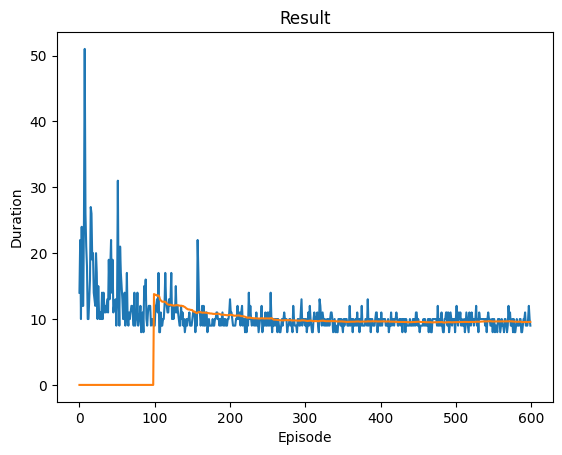

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [20]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 60

for i_episode in range(num_episodes):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        memory.push(state, action, next_state, reward)

        state = next_state

        optimize_model()

        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = TAU * policy_net_state_dict[key] + (1 - TAU) * target_net_state_dict[key]

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()


In [21]:
from IPython import display as ipythondisplay
from PIL import Image

render_env = gym.make('CartPole-v1', render_mode='rgb_array')

def render_episode(env: gym.Env, max_steps: int):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    screen = env.render()
    images = [Image.fromarray(screen)]

    for i in range(1, max_steps + 1):
        print(f'Frame {i}')
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        screen = env.render()
        images.append(Image.fromarray(screen))

        if terminated or truncated:
            break

    return images

In [22]:
images = render_episode(render_env, 200)
image_file = 'cartpole-v1.gif'
images[0].save(image_file, save_all=True, append_images=images[1:], loop=0, duration=1)

Frame 1
Frame 2
Frame 3
Frame 4
Frame 5
Frame 6
Frame 7
Frame 8
Frame 9
Frame 10
